In [62]:
from dataclasses import dataclass
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf

In [63]:
def plot_series(time, series, format="-", start=0, end=None):
    """Helper function to plot our time series"""
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

In [64]:
def generate_time_series():
    np.genfromtxt('data_co2 - Copy.csv', delimiter=',')
    input = np.genfromtxt('data_co2.csv', delimiter=',',skip_header=1,  dtype=None)
    return input['f0'], input['f1']

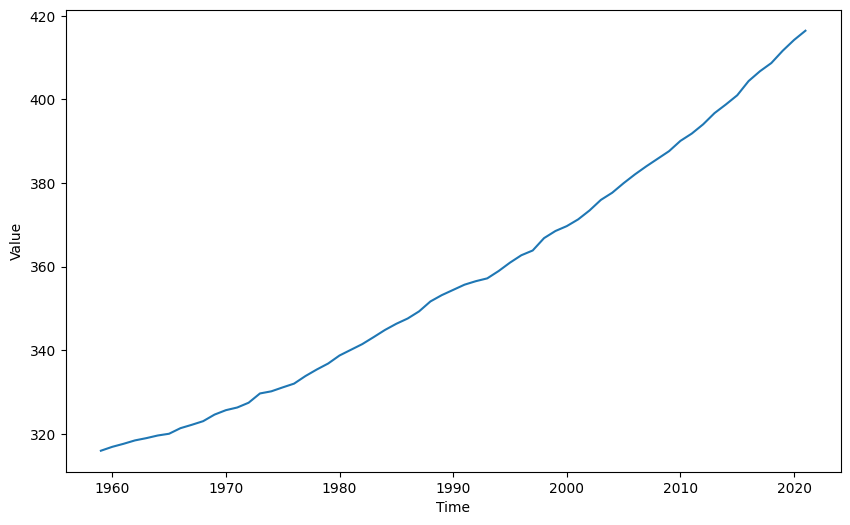

In [65]:
# Let's save the parameters of our time series in the dataclass
@dataclass
class G:
    TIME, SERIES = generate_time_series()
    SPLIT_TIME = 1100  # on day 1100 the training period will end. The rest will belong to the validation set
    WINDOW_SIZE = 20  # how many data points will we take into account to make our prediction
    BATCH_SIZE = 32  # how many items will we supply per batch
    SHUFFLE_BUFFER_SIZE = 1000  # we need this parameter to define the Tensorflow sample buffer


# plot the series
plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

In [66]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):
	"""Divide the time series into training and validation set"""
	time_train = time[:time_step]
	series_train = series[:time_step]
	time_valid = time[time_step:]
	series_valid = series[time_step:]

	return time_train, series_train, time_valid, series_valid

def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
	"""
	We create time windows to create X and y features.
	For example, if we choose a window of 30, we will create a dataset formed by 30 points as X
	"""
	dataset = tf.data.Dataset.from_tensor_slices(series)
	dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
	dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
	dataset = dataset.shuffle(shuffle_buffer)
	dataset = dataset.map(lambda window: (window[:-1], window[-1]))
	dataset = dataset.batch(batch_size).prefetch(1)
	return dataset

In [67]:
# we divide into training and validation set
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

# let's create the dataset with time windows
dataset = windowed_dataset(series_train)

In [68]:
def create_uncompiled_model():
  # define a sequential model
  model = tf.keras.models.Sequential([
      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                    input_shape=[None]),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(1024, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
      tf.keras.layers.Dense(1),
  ])

  return model

In [69]:
class EarlyStopping(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):

    if(logs.get('mae') < 0.03):
      print("\nMAEthreshold reached. Training stopped.")
      self.model.stop_training = True

# Let's create an object of our class and assign it to a variable
early_stopping = EarlyStopping()

In [70]:
def create_model():
    tf.random.set_seed(51)

    model = create_uncompiled_model()

    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  metrics=["mae"])
    return model

model = create_model()

# we train for 20 epochs with and assign the callback
history = model.fit(dataset, epochs=20, callbacks=[early_stopping])

Epoch 1/20
2/2 [==============================] - 24s 2s/step - loss: 371.3543 - mae: 371.8543
Epoch 2/20
2/2 [==============================] - 4s 2s/step - loss: 367.1519 - mae: 367.6519
Epoch 3/20
2/2 [==============================] - 4s 2s/step - loss: 364.9910 - mae: 365.4910
Epoch 4/20
2/2 [==============================] - 4s 2s/step - loss: 363.3644 - mae: 363.8644
Epoch 5/20
2/2 [==============================] - 4s 2s/step - loss: 361.9020 - mae: 362.4020
Epoch 6/20
2/2 [==============================] - 4s 2s/step - loss: 360.5569 - mae: 361.0569
Epoch 7/20
2/2 [==============================] - 4s 2s/step - loss: 359.3865 - mae: 359.8865
Epoch 8/20
2/2 [==============================] - 4s 2s/step - loss: 358.4425 - mae: 358.9425
Epoch 9/20
2/2 [==============================] - 4s 2s/step - loss: 357.6997 - mae: 358.1997
Epoch 10/20
2/2 [==============================] - 4s 2s/step - loss: 357.1080 - mae: 357.6080
Epoch 11/20
2/2 [==============================] - 4s 2s/s

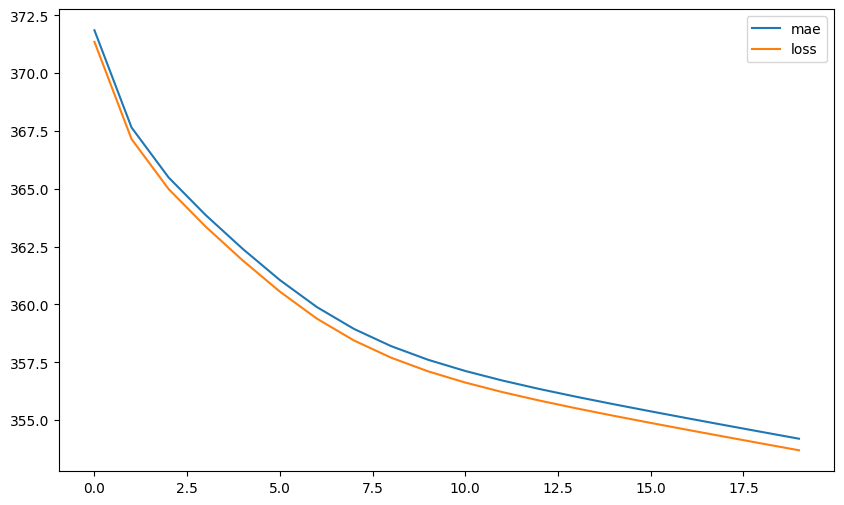

In [71]:
# plot MAE and loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['mae'], label='mae')
plt.plot(history.history['loss'], label='loss')
plt.legend()
plt.show()

In [72]:
def compute_metrics(true_series, forecast):
    """Helper to print MSE and MAE"""
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

def model_forecast(model, series, window_size):
    """This function converts the input series into a dataset with time windows for forecasting"""
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

2/2 [==============================] - 9s 371ms/step


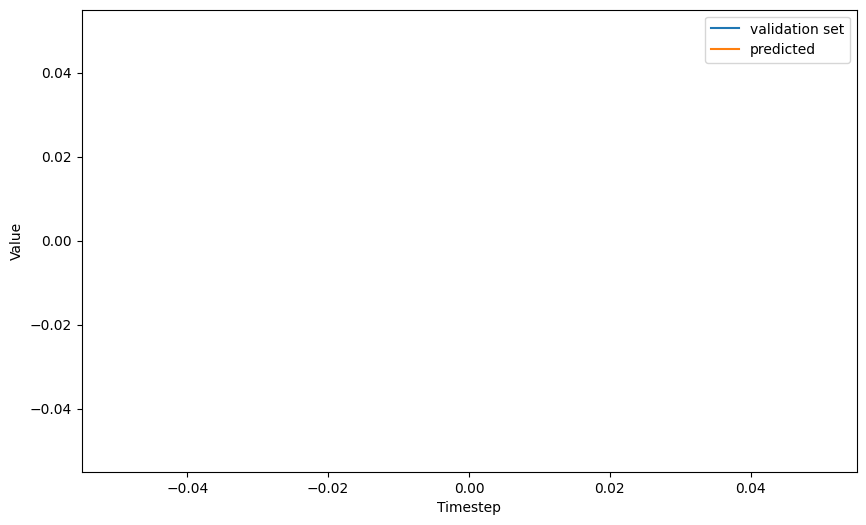

In [73]:
# Prediction on the whole series
all_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze()

# Validation portion
val_forecast = all_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(series_valid, label="validation set")
plt.plot(val_forecast, label="predicted")
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.legend()
plt.show()

In [74]:
val_forecast

array([], dtype=float32)

In [75]:
mse, mae = compute_metrics(series_valid, val_forecast)
print(f"mse: {mse:.2f}, mae: {mae:.2f}")

mse: nan, mae: nan


In [76]:
np.arange(4 * 365 + 1, dtype="float32")

array([0.000e+00, 1.000e+00, 2.000e+00, ..., 1.458e+03, 1.459e+03,
       1.460e+03], dtype=float32)